In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Softmax分类器
class SoftmaxClassifier:
    
    #初始化分类器
        #:param train_data: ndarray of n_data x n_feats
        #:param train_label: array of length n_data
        #:param n_classes: integer of n_classes
    def __init__(self, train_data, train_label, n_classes):
        
        if len(train_data.shape)>2:
            raise ValueError("需要先将训练数据变成二维矩阵")
        
        #加载数据集    
        self.train_data = train_data 
        
        #增广数据矩阵(多1列)
        n_data, n_features = train_data.shape
        self.train_data =np.ones((n_data, n_features+1), dtype = np.float)
        self.train_data[:,1:] = train_data #第一列是1，其他为原数据矩阵
        self.n_data, self.n_features = self.train_data.shape
        
        self.n_classes = n_classes
        
        #加载标签
        self.train_label = train_label
        
        #onehot编码
        self.one_hot = np.zeros((self.n_data, self.n_classes))
        for i in range(n_data):
            self.one_hot[i, train_label[i]] = 1
            
        #随机初始化W矩阵
        self.W = np.random.rand(self.n_classes, self.n_features)
        
        #打印检查
        print("n_classes:", self.n_classes)
        print("n_data:", self.n_data)
        print("n_feats", self.n_features)
        print("train_data.shape:", self.train_data.shape)
        print("train_label.shape:", self.train_label.shape)
        print("W.shape:", self.W.shape)
     
    
    #假设函数softmax
    def softmax(self,x):
        
        #对单个样本向量
        if len(x.shape) == 1:
            numerator = np.exp(self.W @ x.reshape(-1, 1)).flatten()
            denominator = numerator.sum()
        #对样本矩阵
        else:
            numerator = np.exp(self.W @ x.T)
            denominator = numerator.sum(axis = 0)
            
        return numerator/denominator
            
        
    #损失函数 cross entropy
    def loss(self):
        
        softmax_matrix = self.softmax(self.train_data)
        total = 0
        for i in range(self.n_data):
            true_label = self.train_label[i]
            total += np.log(softmax_matrix[true_label, i])
        
        return -total/self.n_data 
    
    
    #对测试样本进行分类
    def predict(self, test_data):
        
        probability = self.softmax(test_data)
        #对单个样本
        if len(probability.shape)<2:
            return np.argmax(probability)
        #对样本矩阵
        else:
            return np.argmax(probability, axis=0)
    
    
    #训练正确率
    def train_accuracy(self):
        predict_result = self.predict(self.train_data)
        n_true_predict = (predict_result == self.train_label).sum()
        return n_true_predict/self.n_data
    
    
    #用SGD训练Softmax分类器
        #:param lr learning rate
    def train(self, lr, n_epoch, early_stop=True):
        
        print("开始训练……")
        loss_list = [self.loss()]
        acc_list = [self.train_accuracy()]
        print(f"loss: {loss_list[-1]},train accuracy: {acc_list[-1]*100}%") #输出列表最后一个元素
        
        #使用梯度下降更新参数
        for current_epoch in range(1, n_epoch+1):
            print(f"Epoch {current_epoch} starts")
            
#             #调整learning rate
#             if current_epoch == 20:
#                 lr /= 2
#             if current_epoch == 50:
#                 lr /= 2
            
            #计算梯度
            grad = 0
            for i in range(self.n_data):
                x_i = self.train_data[i]
                grad += np.outer(self.softmax(x_i)-self.one_hot[i],x_i)
            grad /= self.n_data
            #更新梯度
            self.W -= lr*grad
            
            loss_list.append(self.loss())
            acc_list.append(self.train_accuracy())
            print(f"loss: {loss_list[-1]},train accuracy: {acc_list[-1]*100}%") #输出列表最后一个元素
            
            if early_stop:
                if current_epoch > 0.2*n_epoch and abs(loss_list[-1]-loss_list[-2]) < 1e-3 \
                        and abs(loss_list[-2]-loss_list[-3]) <1e-3:
                    break
                    
        return np.array(loss_list), np.array(acc_list)
    


In [2]:
#二值化
    #:param array: 数组
    #:param th: 阈值
    #:return: 二值化矩阵（0和1）
def binarize(array, threshold):
    return (array>threshold).astype(np.int8)

#针对二维矩阵进行归一化
def normalize(array):
    min_vals = array.min(axis = 0)
    max_vals = array.max(axis = 0)
    return (array - min_vals) / (max_vals - min_vals), min_vals, max_vals

In [3]:
#使用PCA分析降维数据
    #:param project_dim: the dimension of projected data
    #:return: the projection weight matrix
def PCA(train_data, train_label, project_dim = 2, n_classes =10):
    
    #检测数据维数是否正确
    if project_dim >= n_classes:
        raise ValueError("PCA的投影维数必须小于类数")
     
    n_data, n_features = train_data.shape
    
    m = np.average(train_data, axis = 0)
    
    S = np.zeros((n_features, n_features))
    for label in range(n_classes):
        index_of_class = np.argwhere(train_label == label) #得到所有同类样本的索引
        temp = np.zeros((n_features, n_features))
        for i in index_of_class:
            temp += np.outer(train_data[i]-m, train_data[i]-m)
#             print(np.outer(train_data[i]-m, train_data[i]-m).shape)
        S += temp    
        
        
    eigenvalues, eigenvectors = np.linalg.eig(S) #获得S矩阵的特征值、特征向量
    
    eigen_index = np.argsort(eigenvalues)[::-1][:project_dim]
    
    W = eigenvectors[:, eigen_index].astype(float)
    
    return W

In [4]:
#读取训练集图像    
with open("./train-images-idx3-ubyte", "rb") as f:
    f.read(4) #从文件当前位置起读取4个字节
    train_image_count = int.from_bytes(f.read(4),'big') #把bytes类型的变量转化为十进制整数，big为正常顺序
    row_count = int.from_bytes(f.read(4), 'big')
    column_count = int.from_bytes(f.read(4), 'big')
    train_image_data = f.read()  # 剩余的所有字节至文件结束
    train_images = np.frombuffer(train_image_data, dtype = np.uint8).reshape(
        (train_image_count, row_count * column_count))

#读取训练集标签
with open("./train-labels-idx1-ubyte", "rb") as f:
    f.read(8)
    label_data = f.read() 
    train_labels = np.frombuffer(label_data, dtype = np.uint8)

#读取测试集图像
with open("./t10k-images-idx3-ubyte", "rb") as f:
    f.read(4) #从文件当前位置起读取4个字节
    test_image_count = int.from_bytes(f.read(4),'big') #把bytes类型的变量转化为十进制整数，big为正常顺序
    row_count = int.from_bytes(f.read(4), 'big')
    column_count = int.from_bytes(f.read(4), 'big')
    test_image_data = f.read()  # 剩余的所有字节至文件结束
    test_images = np.frombuffer(test_image_data, dtype = np.uint8).reshape(
        (test_image_count, row_count * column_count))

#二值化并保存
binary_train_images = binarize(train_images, 100) #threshold = 100
binary_test_images = binarize(test_images, 100)
np.save("binary-train-images.npy", binary_train_images)
np.save("binary-test-images.npy", binary_test_images)


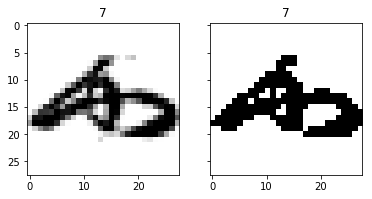

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex='all', sharey='all')
img_2 = binary_train_images[1].reshape(28, 28)
img = train_images[1].reshape(28, 28)
# plt.subplot(2,2,1)
ax[0].set_title(train_labels[1])
ax[0].imshow(img, cmap='Greys', interpolation='nearest')
# plt.subplot(2,2,2)
ax[1].set_title(train_labels[1])
ax[1].imshow(img_2, cmap='Greys', interpolation='nearest')

In [6]:
# #任务一
# cls = SoftmaxClassifier(binary_train_images, train_labels, n_classes = 10)
# loss_list, acc_list = cls.train(lr = 1.5, n_epoch = 100) # lr=0.5时提升效果不明显

# plt.plot(loss_list, linewidth = '2', label = 'Loss')
# plt.plot(acc_list, linewidth = '2', label = 'Accuracy')
# plt.xticks(fontsize = 14)
# plt.yticks(fontsize = 14)
# plt.xlabel("Epoch", fontsize = 14)
# # plt.ylabel("Loss", fontsize = 14)
# plt.show()

# augmented_binary_test_images = np.ones((test_image_count, row_count*column_count+1))
# augmented_binary_test_images[:,1:] = binary_test_images
# predict_result = cls.predict(augmented_binary_test_images)
# print(predict_result)

# with open('task1_test_prediction.csv', 'w', encoding = 'utf-8') as f:
#     for i in range(test_image_count):
#         f.write(f'./test{i}.jpg,{predict_result[i]}\n')

In [7]:
# #任务一_2.0
# cls = SoftmaxClassifier(binary_train_images, train_labels, n_classes = 10)
# loss_list, acc_list = cls.train(lr = 3, n_epoch = 100) # lr=0.5时提升效果不明显

# plt.plot(loss_list, linewidth = '2', label = 'Loss')
# plt.plot(acc_list, linewidth = '2', label = 'Accuracy')
# plt.xticks(fontsize = 14)
# plt.yticks(fontsize = 14)
# plt.xlabel("Epoch", fontsize = 14)
# # plt.ylabel("Loss", fontsize = 14)
# plt.show()

# augmented_binary_test_images = np.ones((test_image_count, row_count*column_count+1))
# augmented_binary_test_images[:,1:] = binary_test_images
# predict_result = cls.predict(augmented_binary_test_images)
# print(predict_result)

# with open('task1_test_prediction.csv', 'w', encoding = 'utf-8') as f:
#     for i in range(test_image_count):
#         f.write(f'./test{i}.jpg,{predict_result[i]}\n')

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


n_classes: 10
n_data: 60000
n_feats 785
train_data.shape: (60000, 785)
train_label.shape: (60000,)
W.shape: (10, 785)
开始训练……
loss: 5.6403563262101795,train accuracy: 11.205%
Epoch 1 starts
loss: 4.599056692787947,train accuracy: 17.935000000000002%
Epoch 2 starts
loss: 3.6000702223056193,train accuracy: 23.808333333333334%
Epoch 3 starts
loss: 3.1217959663293158,train accuracy: 31.211666666666666%
Epoch 4 starts
loss: 2.8704537665104968,train accuracy: 34.833333333333336%
Epoch 5 starts
loss: 2.52390471077677,train accuracy: 39.79833333333333%
Epoch 6 starts
loss: 2.3825671452116532,train accuracy: 42.46%
Epoch 7 starts
loss: 2.2281876570945034,train accuracy: 45.653333333333336%
Epoch 8 starts
loss: 2.1133013972204986,train accuracy: 47.58166666666666%
Epoch 9 starts
loss: 1.9928396107582147,train accuracy: 50.18666666666667%
Epoch 10 starts
loss: 1.9015376849062693,train accuracy: 51.623333333333335%
Epoch 11 starts
loss: 1.8174521981907226,train accuracy: 53.61666666666667%
Epoch 12

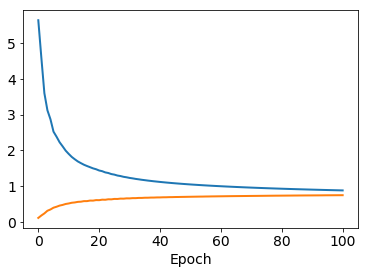

[5 9 3 ... 9 7 1]


In [8]:
#任务一_3.0
cls = SoftmaxClassifier(binary_train_images, train_labels, n_classes = 10)
loss_list, acc_list = cls.train(lr = 0.8, n_epoch = 100) # lr=0.5时提升效果不明显

plt.plot(loss_list, linewidth = '2', label = 'Loss')
plt.plot(acc_list, linewidth = '2', label = 'Accuracy')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Epoch", fontsize = 14)
# plt.ylabel("Loss", fontsize = 14)
plt.show()

augmented_binary_test_images = np.ones((test_image_count, row_count*column_count+1))
augmented_binary_test_images[:,1:] = binary_test_images
predict_result = cls.predict(augmented_binary_test_images)
print(predict_result)

with open('task1_test_prediction.csv', 'w', encoding = 'utf-8') as f:
    for i in range(test_image_count):
        f.write(f'./test{i}.jpg,{predict_result[i]}\n')

[[-6.77206216e-05  4.19527608e-04 -1.16634407e-05 ...  1.06228551e-04
   3.79643833e-04  7.48951445e-05]
 [-4.72976894e-05  1.25276672e-03  6.81825456e-05 ...  1.86491992e-04
   1.16309984e-03 -3.87594686e-04]
 [-1.71271580e-04  2.06595715e-03  5.08376019e-04 ...  7.54836258e-04
   1.80659850e-03 -2.42321421e-05]
 ...
 [-1.66275086e-03  4.05898565e-03  6.61637172e-03 ...  5.96694974e-03
   1.81727848e-03  1.65835666e-03]
 [-9.53981993e-04  2.17616860e-03  3.76637623e-03 ...  3.22746692e-03
   8.57331721e-04  9.18842256e-04]
 [-3.12494220e-04  5.32799921e-04  1.02569813e-03 ...  9.55251992e-04
   2.27828013e-04  1.29182280e-04]]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


n_classes: 10
n_data: 60000
n_feats 10
train_data.shape: (60000, 10)
train_label.shape: (60000,)
W.shape: (10, 10)
开始训练……
loss: 2.463916231632838,train accuracy: 10.94%
Epoch 1 starts
loss: 2.375498495315808,train accuracy: 13.33%
Epoch 2 starts
loss: 2.3271444742986747,train accuracy: 16.143333333333334%
Epoch 3 starts
loss: 2.297518796847563,train accuracy: 18.961666666666666%
Epoch 4 starts
loss: 2.278236651235176,train accuracy: 20.255000000000003%
Epoch 5 starts
loss: 2.265115248673749,train accuracy: 20.698333333333334%
Epoch 6 starts
loss: 2.2557705942811124,train accuracy: 21.278333333333332%
Epoch 7 starts
loss: 2.2487536233929357,train accuracy: 21.691666666666666%
Epoch 8 starts
loss: 2.2431639379179895,train accuracy: 22.035%
Epoch 9 starts
loss: 2.238442248440387,train accuracy: 22.165000000000003%
Epoch 10 starts
loss: 2.234244654416757,train accuracy: 22.47833333333333%
Epoch 11 starts
loss: 2.23036244386034,train accuracy: 22.81833333333333%
Epoch 12 starts
loss: 2.2266

loss: 1.943533724197358,train accuracy: 57.22166666666667%
Epoch 111 starts
loss: 1.9411512859883608,train accuracy: 57.30333333333333%
Epoch 112 starts
loss: 1.9387778715607513,train accuracy: 57.37166666666666%
Epoch 113 starts
loss: 1.9364134472799879,train accuracy: 57.47833333333333%
Epoch 114 starts
loss: 1.9340579795606372,train accuracy: 57.550000000000004%
Epoch 115 starts
loss: 1.9317114348671904,train accuracy: 57.62500000000001%
Epoch 116 starts
loss: 1.9293737797151356,train accuracy: 57.70166666666666%
Epoch 117 starts
loss: 1.9270449806717438,train accuracy: 57.785%
Epoch 118 starts
loss: 1.9247250043570625,train accuracy: 57.855000000000004%
Epoch 119 starts
loss: 1.9224138174447984,train accuracy: 57.94166666666667%
Epoch 120 starts
loss: 1.9201113866632475,train accuracy: 58.02333333333334%
Epoch 121 starts
loss: 1.9178176787960952,train accuracy: 58.08833333333333%
Epoch 122 starts
loss: 1.9155326606833956,train accuracy: 58.166666666666664%
Epoch 123 starts
loss: 1.

loss: 1.7286808210228608,train accuracy: 61.629999999999995%
Epoch 221 starts
loss: 1.727104141356908,train accuracy: 61.650000000000006%
Epoch 222 starts
loss: 1.7255332245674755,train accuracy: 61.67%
Epoch 223 starts
loss: 1.7239680458990982,train accuracy: 61.69%
Epoch 224 starts
loss: 1.7224085806908065,train accuracy: 61.714999999999996%
Epoch 225 starts
loss: 1.7208548043756933,train accuracy: 61.73333333333333%
Epoch 226 starts
loss: 1.7193066924812164,train accuracy: 61.748333333333335%
Epoch 227 starts
loss: 1.717764220628901,train accuracy: 61.76166666666667%
Epoch 228 starts
loss: 1.7162273645344066,train accuracy: 61.79%
Epoch 229 starts
loss: 1.7146961000074357,train accuracy: 61.795%
Epoch 230 starts
loss: 1.713170402951743,train accuracy: 61.81666666666666%
Epoch 231 starts
loss: 1.7116502493649612,train accuracy: 61.82666666666666%
Epoch 232 starts
loss: 1.7101356153385854,train accuracy: 61.83166666666666%
Epoch 233 starts
loss: 1.7086264770579385,train accuracy: 61.8

loss: 1.583910820236572,train accuracy: 62.94333333333333%
Epoch 332 starts
loss: 1.582842849362393,train accuracy: 62.94666666666666%
Epoch 333 starts
loss: 1.5817784374017096,train accuracy: 62.94499999999999%
Epoch 334 starts
loss: 1.580717569038431,train accuracy: 62.955000000000005%
Epoch 335 starts
loss: 1.5796602290275383,train accuracy: 62.96166666666667%
Epoch 336 starts
loss: 1.5786064021950479,train accuracy: 62.97166666666667%
Epoch 337 starts
loss: 1.5775560734375766,train accuracy: 62.975%
Epoch 338 starts
loss: 1.5765092277220984,train accuracy: 62.975%
Epoch 339 starts
loss: 1.5754658500856424,train accuracy: 62.97666666666667%
Epoch 340 starts
loss: 1.574425925635058,train accuracy: 62.985%
Epoch 341 starts
loss: 1.5733894395467845,train accuracy: 62.995000000000005%
Epoch 342 starts
loss: 1.5723563770663949,train accuracy: 62.99666666666667%
Epoch 343 starts
loss: 1.5713267235084347,train accuracy: 63.00333333333333%
Epoch 344 starts
loss: 1.570300464256207,train accu

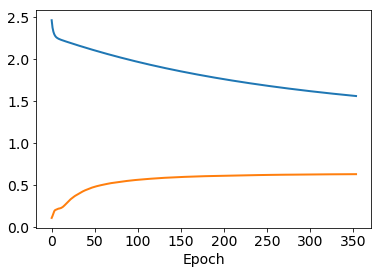

[3 4 3 ... 4 5 6]


In [9]:
#任务二
import pickle
PCA_projection_dim = 9

# #加载模型
# projection_matrix = np.load(f'{PCA_projection_dim}d_projection_matrix.npy')

projection_matrix = PCA(binary_train_images, train_labels, project_dim = PCA_projection_dim, n_classes = 10)
print(projection_matrix)
#储存模型
np.save(f'{PCA_projection_dim}d_projection_matrix.npy',projection_matrix)
   

#对数据进行降维处理
pca_train_images = binary_train_images @ projection_matrix
normalized_pca_train_images, pca_min_vals, pca_max_vals = normalize(pca_train_images)

pca_test_images = binary_test_images @ projection_matrix
normalized_pca_test_images = (pca_test_images-pca_min_vals)/(pca_max_vals-pca_min_vals)
augmented_pca_test_images = np.ones((test_image_count, PCA_projection_dim +1))
augmented_pca_test_images[:, 1:] = normalized_pca_test_images

#加载模型
cls = SoftmaxClassifier(normalized_pca_train_images, train_labels, n_classes = 10)
loss_list, acc_list = cls.train(lr = 0.8, n_epoch = 500) # lr=0.5时提升效果不明显


with open('./SoftmaxClassifier.dat','wb') as f:
    pickle.dump(cls, f)
# with open('./SoftmaxClassifier.dat','rb') as f:
#         cls= pickle.load(f)

plt.plot(loss_list, linewidth = '2', label = 'Loss')
plt.plot(acc_list, linewidth = '2', label = 'Accuracy')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Epoch", fontsize = 14)
# plt.ylabel("Loss", fontsize = 14)
plt.show()

predict_result = cls.predict(augmented_pca_test_images)
print(predict_result)

with open('task2_test_prediction.csv', 'w', encoding = 'utf-8') as f:
    for i in range(test_image_count):
        f.write(f'./test{i}.jpg,{predict_result[i]}\n')

Text(0.5, 1.0, 'PCA Scatter Plot')

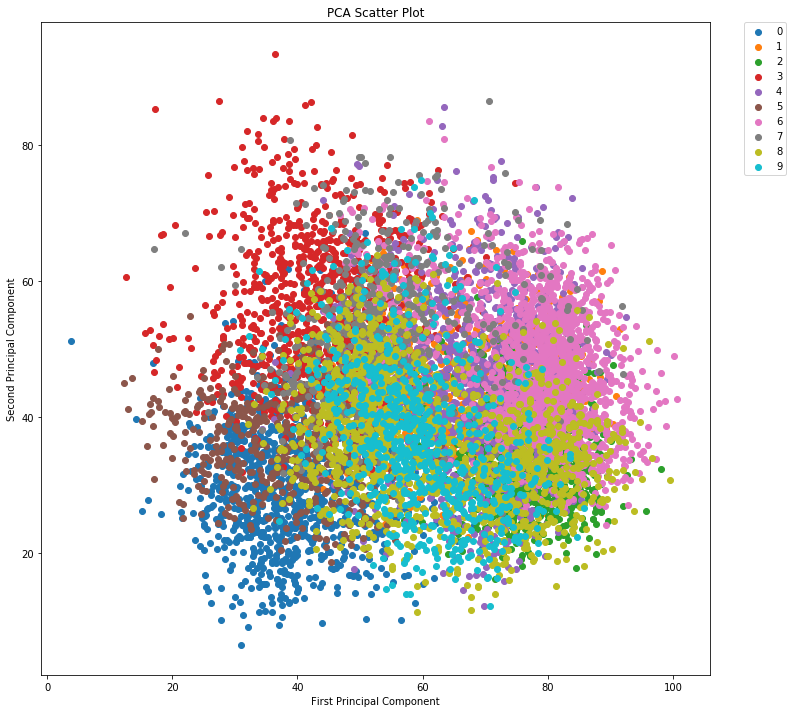

In [10]:
colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
# colors = ['black', 'blue', 'purple', 'yellow', 'white', 'red', 'lime', 'cyan', 'orange', 'gray']
plt.figure(figsize=(12,12))
for i in range(len(colors)):
    x = augmented_pca_test_images[:, 1][predict_result[0:] == i]*100
    y = augmented_pca_test_images[:, 4][predict_result[0:] == i]*100
    plt.scatter(x, y, c=colors[i])


plt.legend(['0','1','2','3','4','5','6','7','8','9'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
# 设置标题
plt.title("PCA Scatter Plot")